In [1]:
# data processing
import numpy as np
import pandas as pd
# plotting
from matplotlib.pyplot import *

In [2]:
style.use(['dark_background', 'bmh']); rc('axes', facecolor='k'); rc('figure', figsize=(8,4), dpi=200)

Let's load a parquest dataset and inspect its contents. I would like to produce conditional PSTH's using panda and compare multiple binning choices.
Also, I would like to produce tensors that can be used for training Vector Autoregressive processes

In [3]:
%load_ext autoreload
%autoreload 2
from api_neurotask import *    # load the NeuroTask API

In [8]:
parquet_file_path = 'NeuroTask/2_10_Chowdhury_CObump.parquet' # original data was sampled at 30 kHz
df, binSize, maxNeuronColList, eventColList, covariateColList = load_and_filter_parquet(parquet_file_path) # returns a panda DataFrame
dt = binSize / 1000 # convert to seconds
# Q: are we using REPEATED type for the neurons in parquet schema? (I'm guessing not)

Data loaded from NeuroTask/2_10_Chowdhury_CObump.parquet with bin size of 1e+01 ms
Max No of Units: 167
Events columns: ['EventTarget_Onset', 'EventGo_cue', 'EventBump']
Covariates columns: ['hand_pos_x', 'hand_pos_y', 'hand_vel_x', 'hand_vel_y', 'bump_dir', 'target_dir']
<class 'list'>


In [5]:
import json

# Kaggle metadata is in the Croissant format
with open('NeuroTask/neurotask-multi-tasks-benchmark-dataset-metadata.json', 'r') as f:
    croissant_metadata = json.load(f)

print(croissant_metadata['datePublished']) # which version of the dataset is this? we can at least identify the last upload time stamp

2024-06-01T19:01:29.0388094


In [9]:
for colName in eventColList + covariateColList:
    print(f'{colName}: {df[colName].dtype}')
# Q: why is trial_id float64?
# Q: what unit are Bump_time in? (in number of bins? rebinning automatically fixes this?)
# Q: how can I map the animal ID to the animal name of the original dataset?

EventTarget_Onset: bool
EventGo_cue: bool
EventBump: bool
hand_pos_x: float64
hand_pos_y: float64
hand_vel_x: float64
hand_vel_y: float64
bump_dir: float64
target_dir: float64
Neuron1: uint8
Neuron2: uint8
Neuron3: uint8
Neuron4: uint8
Neuron5: uint8
Neuron6: uint8
Neuron7: uint8
Neuron8: uint8
Neuron9: uint8
Neuron10: uint8
Neuron11: uint8
Neuron12: uint8
Neuron13: uint8
Neuron14: uint8
Neuron15: uint8
Neuron16: uint8
Neuron17: uint8
Neuron18: uint8
Neuron19: uint8
Neuron20: uint8
Neuron21: uint8
Neuron22: uint8
Neuron23: uint8
Neuron24: uint8
Neuron25: uint8
Neuron26: uint8
Neuron27: uint8
Neuron28: uint8
Neuron29: uint8
Neuron30: uint8
Neuron31: uint8
Neuron32: uint8
Neuron33: uint8
Neuron34: uint8
Neuron35: uint8
Neuron36: uint8
Neuron37: uint8
Neuron38: uint8
Neuron39: uint8
Neuron40: uint8
Neuron41: uint8
Neuron42: uint8
Neuron43: uint8
Neuron44: uint8
Neuron45: uint8
Neuron46: uint8
Neuron47: uint8
Neuron48: uint8
Neuron49: uint8
Neuron50: uint8
Neuron51: uint8
Neuron52: uint8
N

In [8]:
for colName in nonNeuronCols:
    if df[colName].dtype == np.int64:
        print(f'{colName}: {df[colName].unique()}')

datasetID: [2]
session: [1 2]
animal: [1 2]


In [9]:
animalList = df['animal'].unique()
for animal in animalList:
    print(f'Animal {animal} has {df[df["animal"] == animal]["session"].unique()} sessions.')

animal = animalList[-1]
sessionList = df[df["animal"] == animal]['session'].unique()
session = sessionList[-1]
print(f'(animal = {animal}, session = {session}) chosen')

Animal 1 has [1 2] sessions.
Animal 2 has [1 2] sessions.
(animal = 2, session = 2) chosen


In [10]:
# or do it the panda way
df.groupby(['animal', 'session'])['trial_id'].nunique().reset_index(name='unique_trials_per_session')

,animal,session,unique_trials_per_session
0,1,1,637
1,1,2,1388
2,2,1,710
3,2,2,951


In [11]:
dfNeurons = df[(df['session'] == session) & (df['animal'] == animal)].dropna(axis=1, how='all')
Y = dfNeurons[[col for col in dfNeurons.columns if col.startswith('Neuron')]].to_numpy()
Y.shape

(198683, 155)

In [12]:
Sigma_Y = np.cov(Y, rowvar=False)

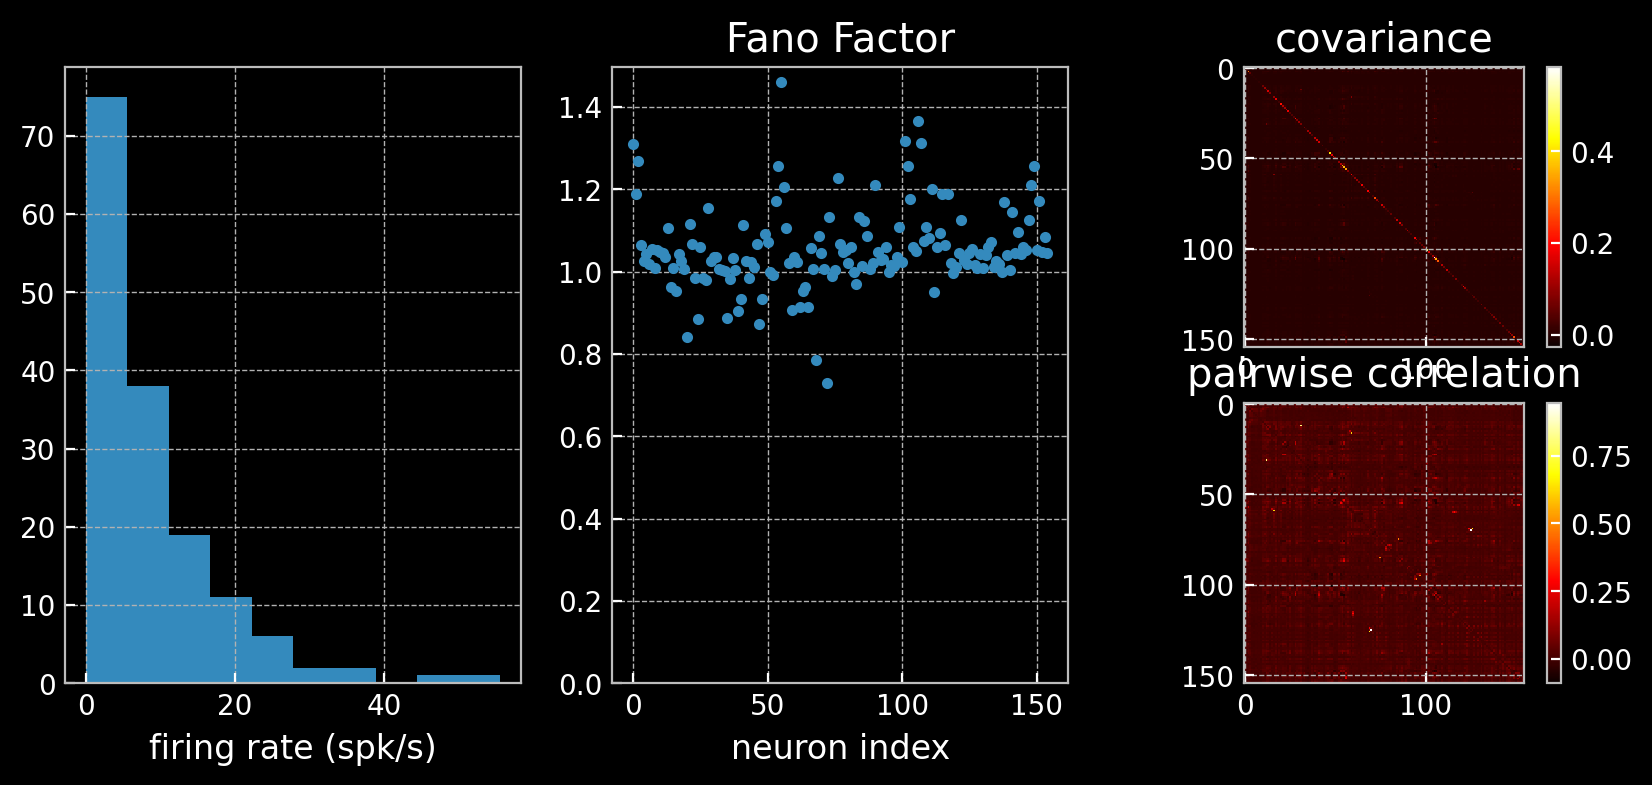

In [13]:
figure(figsize=(10,4))
subplot(1,3,1)
hist(np.nanmean(Y, axis=0) / binSize); xlabel('firing rate (spk/s)');
subplot(1,3,2)
plot(Sigma_Y.diagonal() / np.nanmean(Y, axis=0), '.'); title('Fano Factor'); xlabel('neuron index'); ylim(bottom=0)
subplot(2,3,3)
imshow((Sigma_Y), cmap='hot', interpolation='nearest')
colorbar()
title('covariance')
subplot(2,3,6)
CC_Y = np.corrcoef(Y, rowvar=False)
imshow((CC_Y - np.diag(np.diag(CC_Y))), cmap='hot', interpolation='nearest')
title('pairwise correlation')
colorbar()

In [14]:
# Let's smooth a little bit over time with a boxcar of length 10
from scipy.signal import convolve
# Ysmooth = convolve(Y, np.ones(10)/10, axis=0, mode='same')
# pd.concat([fhandle for _, group in df.groupby(['animal','session','trial_id'], group_keys=True)], ignore_index=False) # <-- no smoothing across trial boundaries
Ysmooth = np.apply_along_axis(lambda y: convolve(y, np.ones(100)/100, mode='same'), axis=0, arr=Y) # <-- INCORRECTLY smoothing across trial boundaries (but we don't care for now)

Text(0, 0.5, 'firing rate')

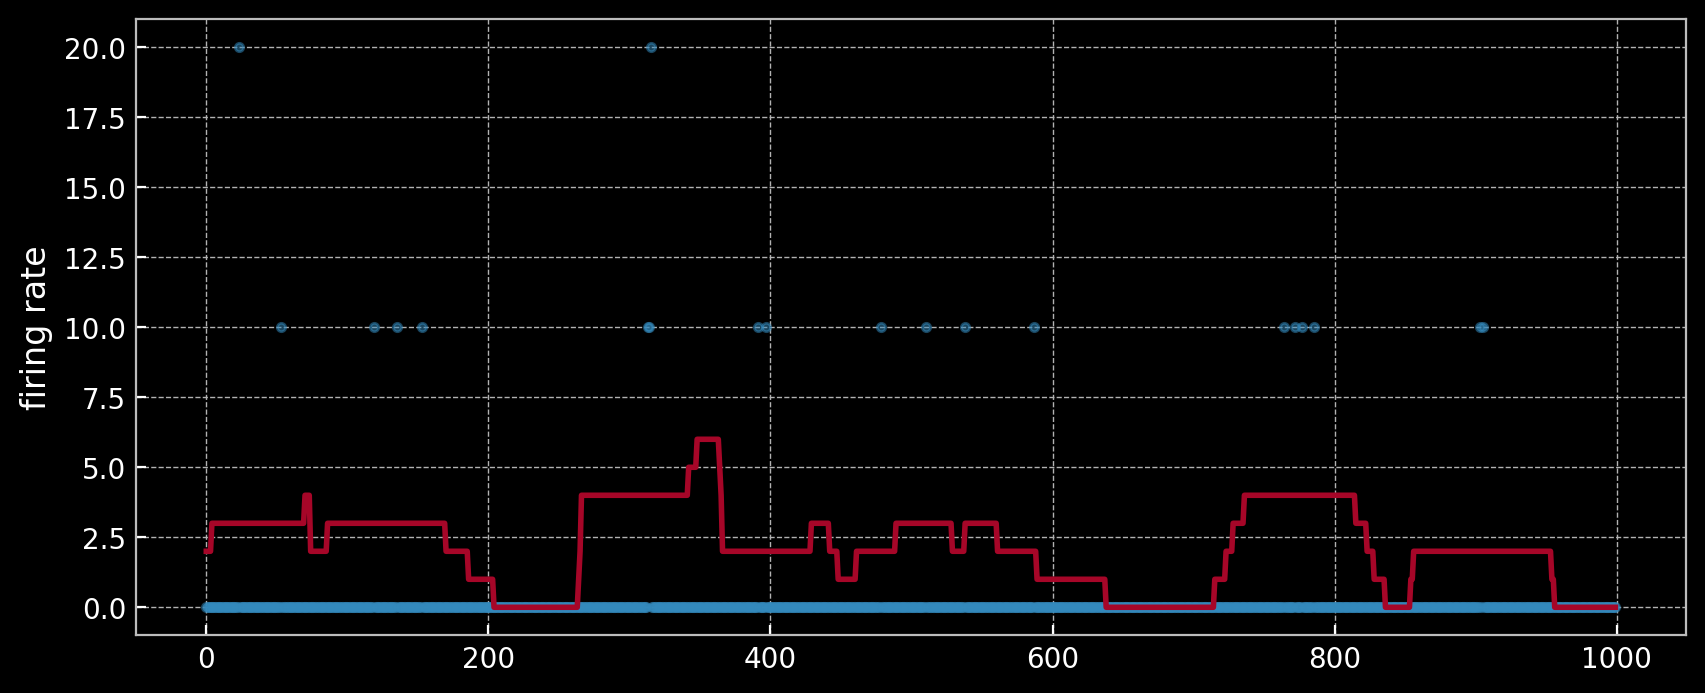

In [15]:
figure(figsize=(10,4))
neuronIdx = 1
plot(Y[1000:2000, neuronIdx] * 10, '.', alpha=0.5)
plot(Ysmooth[1000:2000, neuronIdx] / binSize); ylabel('firing rate')

1


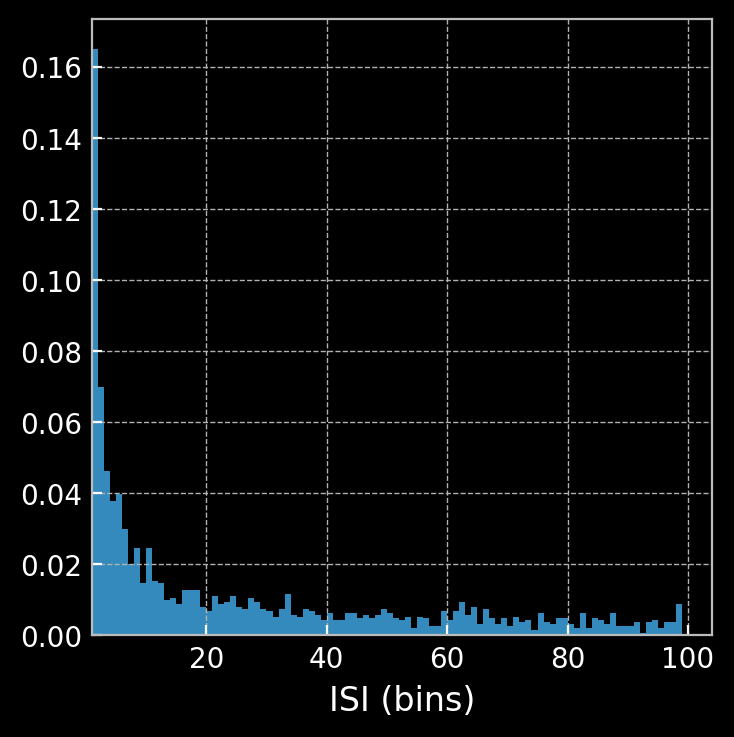

In [16]:
# something's off. let me take a look at the inter-spike interval distribution
figure(figsize=(4,4))
ISI = np.diff(np.where(Y[:, neuronIdx] != 0)[0], axis=0) # * binSize;
hist(ISI, bins=np.arange(0, 100, 1), density=True); xlim(left=1); xlabel('ISI (bins)')
# ISI = np.diff(np.where(Y[:, neuronIdx] != 0)[0], axis=0) * binSize;
# hist(ISI * 1e3, bins=np.arange(0, 100, 1), density=True); xlim(left=binSize); xlabel('ISI (ms)')
print(ISI.min())

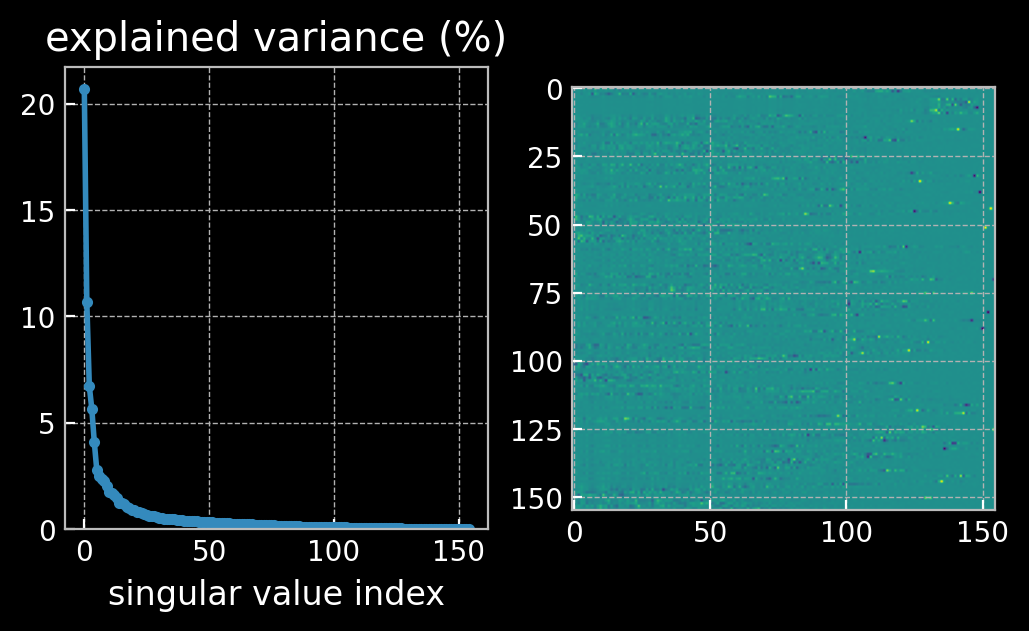

In [17]:
# Let's do a quick PCA to find the axes to project the data on later
[U, S, VT] = np.linalg.svd(np.cov(Ysmooth, rowvar=False))
figure(figsize=(6,3))
subplot(1,2,1)
plot(S / np.sum(S) * 100, '.-'); title('explained variance (%)'); xlabel('singular value index'); ylim(bottom=0)
subplot(1,2,2)
imshow(U)
#plot(U[:, 0])
#plot(U[:, 1])

In [ ]:
# Let's plot a single trial
trial_id = 3
trial_data = df[(df['trial_id'] == trial_id) & (df['session'] == session) & (df['animal'] == animal)]

# Identify event columns
event_columns = ['Go_cue', 'Target_Onset', 'Bump_time']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot events per time for the selected neurons
for neuron in neurons:
    events = trial_data.index[trial_data[neuron] == 1].tolist()
    ax.eventplot(events, lineoffsets=neurons.index(neuron), linelengths=0.5, color='black')

# Plot event indications as vertical lines for each event type
colors = ['red', 'blue', 'green']
event_labels = []
event_positions = []

for idx, event_col in enumerate(event_columns):
    event_indices = trial_data.index[trial_data[event_col] == 1].tolist()
    for event_index in event_indices:
        ax.axvline(x=event_index, linestyle='-', label=event_col)
        event_positions.append(event_index)
        event_labels.append(event_col)

# Combine event labels for positions with multiple events
event_dict = {}
for pos, label in zip(event_positions, event_labels):
    if pos in event_dict:
        event_dict[pos].add(label)
    else:
        event_dict[pos] = {label}

# Sort events to ensure the ticks are in order
sorted_event_positions = sorted(event_dict.keys())
sorted_event_labels = [', '.join(event_dict[pos]) for pos in sorted_event_positions]

# Set x-axis ticks with event indications
ax.set_xticks(sorted_event_positions)
ax.set_xticklabels(sorted_event_labels, rotation=45, fontsize=12)

# Plot velocity data for y-axis
ax2 = ax.twinx()
ax2.plot(trial_data['hand_vel_y'], color='black', label='vy')
ax2.plot(trial_data['hand_vel_x'], color='blue', label='vx')

# Set y-axis label for velocity
ax2.set_ylabel('Velocity', fontsize=14)

# Increase font sizes for better readability
ax.set_ylabel('Neurons', fontsize=14)
ax.set_title(f'Raster Plot for Trial {trial_id}', fontsize=16)
plt.legend()
# Show plot
plt.show()

## Event alignment

In [18]:
df[(df['session'] == session) & (df['animal'] == animal)]['Bump_time']

640768    0.0
640769    0.0
640770    0.0
640771    0.0
640772    0.0
         ... 
839446    0.0
839447    0.0
839448    0.0
839449    0.0
839450    0.0
Name: Bump_time, Length: 198683, dtype: float64

In [19]:
# dfGO = align_event(df[df['session' == session] & df['animal' == animal]], 'Go_cue', offset_min=20, offset_max=100)
# I: error message when parenthesis is missing between boolean operation of indices is not very helpful; can we make it more helpful?
# dfGO = align_event(df[(df['session' == session]) & (df['animal' == animal])], 'Go_cue', offset_min=20, offset_max=100)
# C: if I first subindex a dataframe then try to align_event, it fails; can we give a more helpful error message?
loffset = -5
roffset = 10
eventName = 'Bump_time'
dfAligned = align_event(df, eventName, offset_min=-loffset, offset_max=roffset)
# C: offset_max should really be called something else...
# Q: can I use negative offset_min?
# Q: what error does it throw if the offset_max is too long?
# C: the string 'Go_cue' needs to be known exactly; can we allow code completion to help with this? We can simply make a list of static variables in the API.

In [20]:
# checking that it's the same DataFrame with the same columns
dfAligned.columns

Index(['Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6',
       'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10',
       ...
       'target_dir', 'Target_Onset', 'Go_cue', 'End_trial', 'Start_trial',
       'Bump_time', 'datasetID', 'session', 'animal', 'task'],
      dtype='object', length=184)

In [21]:
dfAligned = dfAligned[(dfAligned['session'] == session) & (dfAligned['animal'] == animal)] # I know I'm overwriting

In [22]:
dfAligned = dfAligned.dropna(axis=1, how='all') # drop all columns that are all NaN (this removes all 'Neuron' columsn that are all NaN)
neuronCols_subset = [col for col in dfAligned.columns if col.startswith('Neuron')]
print(f'No of Units: {len(neuronCols_subset)}')

No of Units: 155


In [23]:
trialList = dfAligned['trial_id'].unique()
print(f'No of Trials: {len(trialList)}')
neuronNpIdx = [dfAligned.columns.get_loc(col) for col in neuronCols_subset]

tY = np.zeros((len(trialList), 16, len(neuronCols_subset)))
print(tY.shape)

for idx, trial_id in enumerate(trialList):
    trial_data = dfAligned[dfAligned['trial_id'] == trial_id].to_numpy()
    # Q: why are each trial different lengths? I expected offset_min + offset_max + 1 for the time dimension. This is a serious problem.
    tY[idx, :, :] = trial_data[:, neuronNpIdx]

No of Trials: 294
(294, 16, 155)


Text(0, 0.5, 'firing rate (spk/s)')

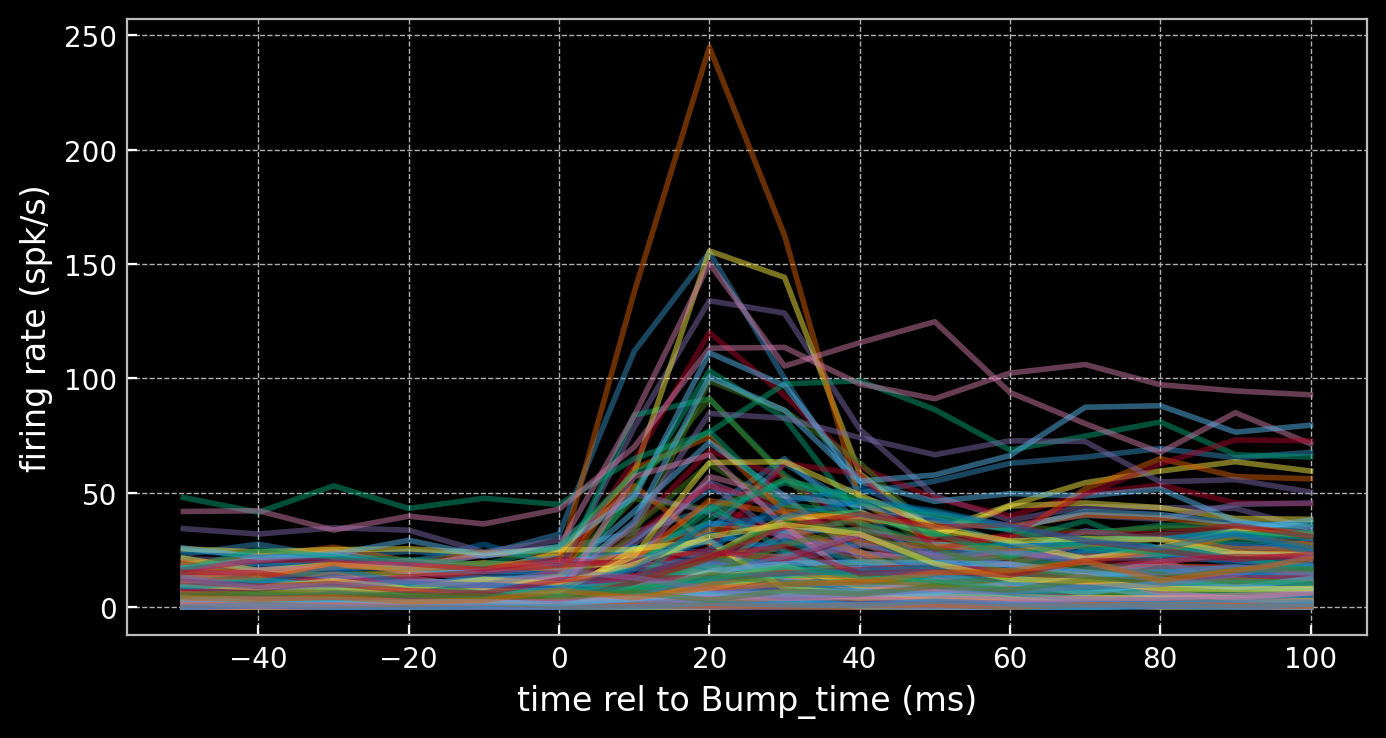

In [24]:
# plot some PSTH
plot(np.arange(loffset, roffset+1) * binSize * 1e3, np.nanmean(tY, axis=0) / binSize, alpha=0.5);
xlabel('time rel to ' + eventName + ' (ms)'); ylabel('firing rate (spk/s)')

In [25]:
# Now let's try to re-bin and do it again
dfRebinned = rebin(df, bin_size=2, reset=True)
binSize *= 2

In [38]:
loffset=-2
roffset=5
print(f'Window size {roffset-loffset+1}')
dfAligned = align_event(dfRebinned, eventName, offset_min=-loffset, offset_max=roffset)
dfAligned = dfAligned.dropna(axis=1, how='all') # drop all columns that are all NaN (this removes all 'Neuron' columsn that are all NaN)
neuronCols_subset = [col for col in dfAligned.columns if col.startswith('Neuron')]
print(f'No of Units: {len(neuronCols_subset)}')

Window size 8
No of Units: 167


In [39]:
dfAligned = dfAligned[(dfAligned['session'] == session) & (dfAligned['animal'] == animal)] # I know I'm overwriting

In [40]:
trialList = dfAligned['trial_id'].unique()
print(f'No of Trials: {len(trialList)}')
neuronNpIdx = [dfAligned.columns.get_loc(col) for col in neuronCols_subset]

tY = np.zeros((len(trialList), (roffset-loffset+1), len(neuronCols_subset)))
print(tY.shape)

for idx, trial_id in enumerate(trialList):
    trial_data = dfAligned[dfAligned['trial_id'] == trial_id].to_numpy()
    # print(trial_data.shape)
    tY[idx, :, :] = trial_data[:, neuronNpIdx]

No of Trials: 294
(294, 8, 167)


Text(0, 0.5, 'firing rate (spk/s)')

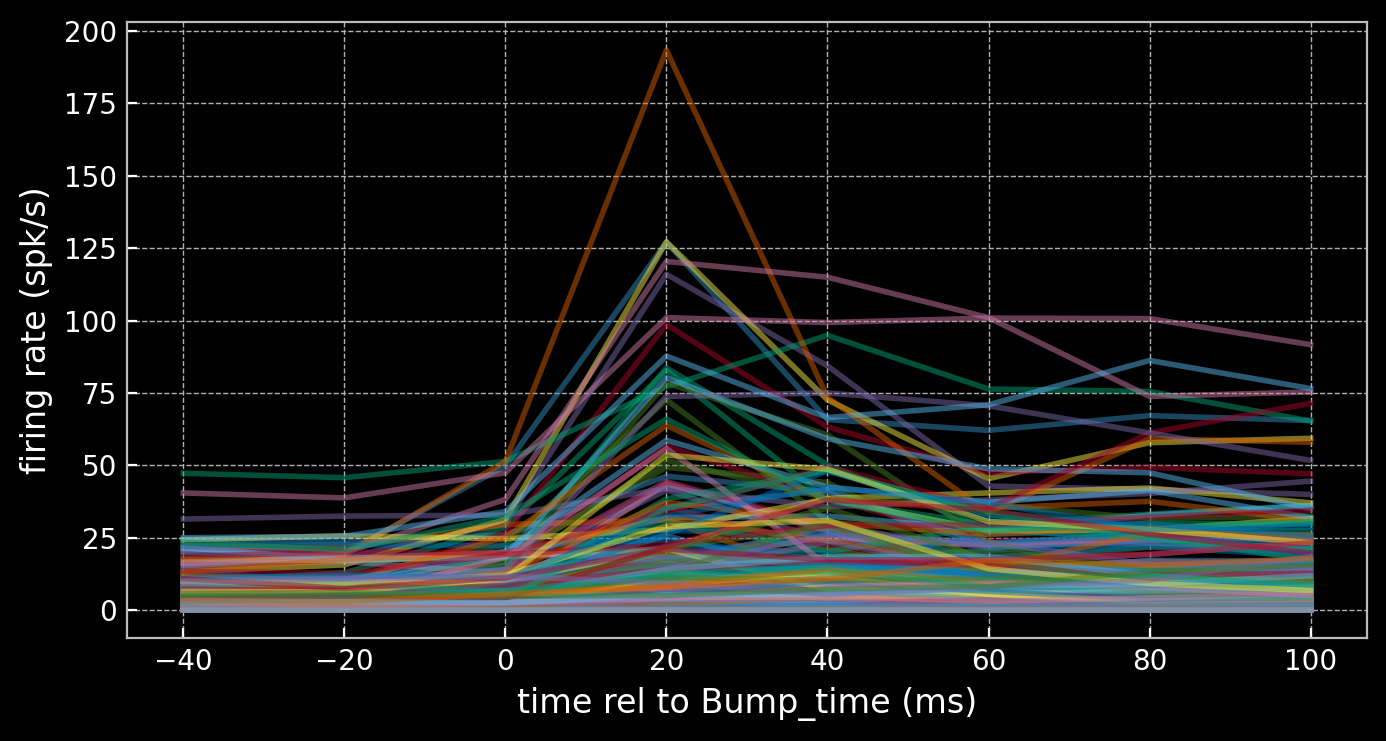

In [44]:
# plot some PSTH
plot(np.arange(loffset, roffset+1) * binSize * 1e3, np.nanmean(tY, axis=0) / binSize, alpha=0.5);
xlabel('time rel to ' + eventName + ' (ms)'); ylabel('firing rate (spk/s)')